### N-Gram Language Model

In [13]:
#imports 
import pandas as pd
import ngram_laplace_lm_model as lm
import numpy as np
import matplotlib.pyplot as plt

import utils 

In [14]:
# special tokens 
SENTENCE_BEGIN = "<s>"
SENTENCE_END = "</s>"

# filepaths 
country_train_filepath = "data/country_train.csv"
country_val_filepath = "data/country_val.csv"
country_test_filepath = "data/country_test.csv"

metal_train_filepath = "data/metal_train.csv"
metal_val_filepath = "data/metal_val.csv"
metal_test_filepath = "data/metal_test.csv"

# constants to change 
NGRAM = 3
NUM_SEQ_TO_GENERATE = 10 # how many lines to generate with our models 
VERBOSE = True

In [15]:
# read in data
country_train_lyrics = pd.read_csv(country_train_filepath, header=None)[0].to_list()
country_val_lyrics = pd.read_csv(country_val_filepath, header=None)[0].to_list()
print("Number of training lines for Country:", len(country_train_lyrics))
print("Number of validation lines for Country:", len(country_val_lyrics))
print()

metal_train_lyrics = pd.read_csv(metal_train_filepath, header=None)[0].to_list()
metal_val_lyrics = pd.read_csv(metal_val_filepath, header=None)[0].to_list()
print("Number of training lines for Heavy Metal:", len(metal_train_lyrics))
print("Number of validation lines for Heavy Metal:", len(metal_val_lyrics))

Number of training lines for Country: 149771
Number of validation lines for Country: 18610

Number of training lines for Heavy Metal: 149771
Number of validation lines for Heavy Metal: 18610


In [16]:
def create_ngram_laplace_model(training_sequences: list, ngram: int = NGRAM, verbose: bool = True):
	"""
	 Creates a trained n-gram language model using Laplace Smoothing using the given training data 

	 Args:
		training_sequences (list): a list of training sequence strings
		ngram (int): the n-gram order of the language model to create
		verbose (bool): if True, prints information about the training data 

	Returns:
		A trained NGramLaplaceLanguageModel
	"""
	tokens = utils.tokenize(training_sequences, ngram)
	model = lm.NGramLaplaceLanguageModel(ngram)
	model.train(tokens, verbose=verbose)

	return model

In [17]:
print("Country Laplace Model:")
laplace_country_model = create_ngram_laplace_model(country_train_lyrics)

Country Laplace Model:
Number of tokens: 1800401
N-gram examples: [('<s>', '<s>', 'i'), ('<s>', 'i', "'ve"), ('i', "'ve", 'seen')]
Vocabulary Size: 11236


In [18]:
print("Heavy Metal Laplace Model:")
laplace_metal_model = create_ngram_laplace_model(metal_train_lyrics)

Heavy Metal Laplace Model:
Number of tokens: 1547349
N-gram examples: [('<s>', '<s>', 'my'), ('<s>', 'my', 'journey'), ('my', 'journey', 'began')]
Vocabulary Size: 14350


#### Generate New Sequences 

In [19]:
# method to help format generated sentences 
def clean_lyric(lyric_tokens: list) -> str:
    """
    Return the given sequence of tokens as a single string without special tokens 
    Args:
        lyric_tokens (list): list of tokens for the generated sequence

    Returns:
        The tokens joined in a single string without special characters 

    """
    lyric_str = ' '.join(lyric_tokens)
    return lyric_str.replace(SENTENCE_BEGIN, '').replace(SENTENCE_END, '').strip()

In [20]:
print("Country Generated Lyrics:\n")
for i in range(NUM_SEQ_TO_GENERATE):
    lyric_tokens = laplace_country_model.generate_sentence()
    print(clean_lyric(lyric_tokens))

Country Generated Lyrics:

you know she 's both feel free
gone are the days to go to california
you get drive-thru , dollar menu
'cause they all know that most of all colors when the moon stills shines as bright as it gets deeper by the way i pack
the way our love has died
i 've got no answers here
i ca n't stand here in tennessee
vancouver may be an american dream
in your eyes
gettin ' in fast forward , some other


In [21]:
print("Heavy Metal Generated Lyrics:\n")
for i in range(NUM_SEQ_TO_GENERATE):
    lyric_tokens = laplace_metal_model.generate_sentence()
    print(clean_lyric(lyric_tokens))

Heavy Metal Generated Lyrics:

invite the plague
forcing pleasure  ,  , mortified entrails and rot in hell
that always hangs above
and everyday i pay for that day
i will insist on you son of mary
generation triple x
of a heartbeat away
eli lema sabachtani
from knowledge drunk from the stinking dirt she rises her head
world ca n't you know that i 'm still in my mind about who really cares


#### Evaluate Perplexity

In [22]:
# using validation to be robust against outliers 
def median_perplexity(model, lines: list, ngram: int=NGRAM, should_truncate: bool=False): 
    """
    Evaluates the given model by finding the median perplexity of the given test sequences. 

    Args:
        model : the  N-gram Language Model 
        lines (list): a list of strings of data to evaluate perplexity on 
        ngram (int): the n-gram order used by the model
        should_truncate (bool): an optional truncation parameter that shortens the sequences to the same length used by RNNs
                                (to make perplexity more comparable between models)

    Returns: median perplexity over the given sequences 
    """
    perplexities = []
    for line in lines:
        if should_truncate:
            line = line[:10]

        test_tokens = utils.tokenize_line(line, ngram)
        perplexities.append(model.perplexity(test_tokens))

    return np.median(perplexities)


# perplexity on data that the models have not seen yet
print("Median Validation Perplexity for Country Model:", median_perplexity(laplace_country_model, country_val_lyrics))
print("Median Validation Perplexity for Heavy Metal Model:", median_perplexity(laplace_metal_model, metal_val_lyrics))

print()

# perplexity on data that the models have not seen yet - truncated 
print("Median Validation Perplexity for Country Model, Lines Truncated:", median_perplexity(laplace_country_model, country_val_lyrics, should_truncate=True))
print("Median Validation Perplexity for Heavy Metal Model, Lines Truncated:", median_perplexity(laplace_metal_model, metal_val_lyrics, should_truncate=True))

Median Validation Perplexity for Country Model: 1205.002805205404
Median Validation Perplexity for Heavy Metal Model: 1944.8382552263183

Median Validation Perplexity for Country Model, Lines Truncated: 674.4858577404832
Median Validation Perplexity for Heavy Metal Model, Lines Truncated: 1304.4708043889343


### Experimentation - Testing out Different NGRAM values

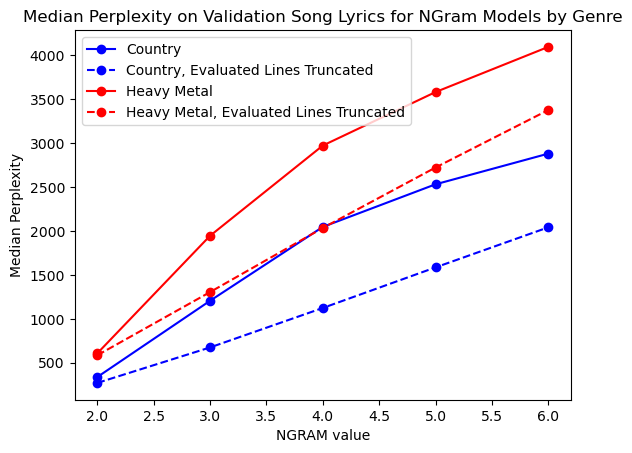

In [23]:
# visualize how NGRAM value impacts perplexity

# NGRAM value for our x-axis 
ngram_val = [2, 3, 4, 5, 6]

# Median Validation Perplexities for y-axis 
val_perplexities_country = [337, 1205, 2046, 2531, 2880]
val_perplexities_country_truncated = [270, 674, 1123, 1585, 2041]
val_perplexities_metal = [607, 1945, 2972, 3581, 4095]
val_perplexities_metal_truncated = [585, 1304, 2034, 2722, 3376]


plt.plot(ngram_val, val_perplexities_country, marker='o', linestyle='-', color='blue', label='Country')
plt.plot(ngram_val, val_perplexities_country_truncated, marker='o', linestyle='--', color='blue', label='Country, Evaluated Lines Truncated')
plt.plot(ngram_val, val_perplexities_metal, marker='o', linestyle='-', color='red', label='Heavy Metal')
plt.plot(ngram_val, val_perplexities_metal_truncated, marker='o', linestyle='--', color='red', label='Heavy Metal, Evaluated Lines Truncated')


plt.xlabel('NGRAM value')
plt.ylabel('Median Perplexity')
plt.title('Median Perplexity on Validation Song Lyrics for NGram Models by Genre')
plt.legend()
plt.show()

##### Country Model 

__ngram=2__
1. perplexity on validation set: 337.8503322927694
1. perplexity on validation set, truncated lines: 270.707519486243
4. example lyrics:\
love , oh wipe each other one without wishin that 's the by\
except what to realize\
put you take you\
he loved her mother\
no chance\
on and who i was there


__ngram=3__
1. perplexity on validation set: 1205.002805205404
1. perplexity on validation set, truncated lines: 674.4858577404832
4. example lyrics:\
i said i will\
and little jeanie 's sake .\
technicolor , river queen , three on high\
when a road with my fiddle\
yes everything i have shown

__ngram=4__
1. perplexity on validation set: 2046.0507074046266
1. perplexity on validation set, truncated lines: 1123.0440974636188
4. example lyrics:\
if heaven 's real\
i do n't know\
one night at a time\
well you nursed me through the valley filled with snow\
we always wear a great big world are we\
on a cloud nine ride

__ngram=5__
1. perplexity on validation set: 2531.502204342474
1. perplexity on validation set, truncated lines: 1585.0532742231758
4. example lyrics:\
lord above me knows i love you\
a beautiful sight , weæš®e happy tonight\
i get along with you\
however you look at it , whatever you believe\
she can crawl it\
'cause it 's beer thirty , and it 's time to go out on a huntin ' spree\

__ngram=6__
1. perplexity on validation set: 2879.999449620529
1. perplexity on validation set, truncated lines: 2040.811904729858
4. example lyrics:\
she do n't really care who 's watchin '\
you can count on me\
and you just ca n't get it through my head you do n't care at all\
i live with angel she 's a roadhouse queen\
you keep my tears flowing\
sing it sweet and sing it low

##### Heavy Metal Model

__ngram=2__
1. perplexity on validation set: 606.7330883081569
1. perplexity on validation set, truncated lines: 585.5194027029972
4. example lyrics:
out all you\
but i hide , hey , dokken ,\
lay you pain\
colder than you make me in fire\
learning life go


__ngram=3__
1. perplexity on validation set: 1944.8382552263183
1. perplexity on validation set, truncated lines: 1304.4708043889343
4. example lyrics:\
oppressions wall they will learn\
mad magicians tinsel nightmares\
a thousand young\
wherever you are too much abuse of wasted human ... debris\
turning bottled water into wine

__ngram=4__
1. perplexity on validation set: 2972.0462423487797
1. perplexity on validation set, truncated lines: 2034.6472475929634
4. example lyrics:\
but now we retaliate\
devoid the fake with full disdain\
boiling in rage - sophisticated cage\
well , i know\
you feel it

__ngram=5__
1. perplexity on validation set: 3581.757352722282
1. perplexity on validation set, truncated lines: 2722.2028257501215
4. example lyrics:\
and now i close the door\
you will forger the pain\
ca n't somebody tell me am i the top of the chain\
just be my human hand\
death from above

__ngram=6__
1. perplexity on validation set: 4095.8146685243028
1. perplexity on validation set, truncated lines: 3375.9122626059634
4. example lyrics:\
confronting unconsciousness\
triumph awaits .\
i ’ ve had all i can take\
you lock me in\
tear down the veil